
**Project Repository:** https://github.com/GokulKarthik/deep-learning-projects-pytorch

### References:
[1] https://github.com/carnotaur/crnn-tutorial/

In [655]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18

import string
from tqdm.notebook import tqdm
import cv2
from PIL import Image, ImageChops
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import multiprocessing as mp

In [656]:
cpu_count = mp.cpu_count()
print(cpu_count)

16


## 1. Make train-test split

**Data Link**: https://www.kaggle.com/shawon10/captcha-recognition

In [657]:
data_path = "./output"

In [658]:
image_fns = os.listdir(data_path)
image_fns = [f"{i}.png" for i in range(len(image_fns))]
print(len(image_fns))
print(np.unique([len(image_fn.split(".")[0]) for image_fn in image_fns]))

10644
[1 2 3 4 5]


In [659]:
# image_fns.remove('samples')
print(len(image_fns))

10644


In [660]:
label = pd.read_csv('./data2.csv')

In [661]:
label

,label
0,732203
1,136284
2,302845
3,221960
4,171392
...,...
9995,526980
9996,498198
9997,411946
9998,8571


In [617]:
data = train_test_split(image_fns, list(map(str, label['label'].to_numpy())), random_state=0)
image_fns_train, image_fns_test, label_train, label_test = data[0], data[1], data[2], data[3]
# data = train_test_split(image_fns, label['label'].to_numpy(), random_state=0)
# print(data)
print(len(image_fns_train), len(image_fns_test))

7983 2661


## 2. Define character maps

In [618]:
image_ns = [str(num) for num in label['label']]
image_ns = "".join(image_ns)
letters = sorted(list(set(list(image_ns))))
print(len(letters))
print(letters)

13
['.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'n']


In [619]:
vocabulary = letters
print(len(vocabulary))
print(vocabulary)
idx2char = {k:v for k,v in enumerate(vocabulary, start=0)}
print(idx2char)
char2idx = {v:k for k,v in idx2char.items()}
print(char2idx)

14
['-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'n']
{0: '-', 1: '.', 2: '0', 3: '1', 4: '2', 5: '3', 6: '4', 7: '5', 8: '6', 9: '7', 10: '8', 11: '9', 12: 'a', 13: 'n'}
{'-': 0, '.': 1, '0': 2, '1': 3, '2': 4, '3': 5, '4': 6, '5': 7, '6': 8, '7': 9, '8': 10, '9': 11, 'a': 12, 'n': 13}


## 3. Define data loader

In [620]:
batch_size = 64

In [621]:
class CAPTCHADataset(Dataset):
    
    def __init__(self, data_dir, image_fns, label):
        self.data_dir = data_dir
        self.image_fns = image_fns
        self.label = label
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.data_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        noise = Image.effect_noise((200, 50), 100).convert('RGB')
        image = ImageChops.multiply(image, noise)
        image = self.transform(image)
        text = self.label[index]
        return image, text
    
    def transform(self, image):
        
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [622]:
trainset = CAPTCHADataset(data_path, image_fns_train, label_train) 
testset = CAPTCHADataset(data_path, image_fns_test, label_test)
train_loader = DataLoader(trainset, batch_size=batch_size, num_workers=0, shuffle=True)
test_loader = DataLoader(testset, batch_size=batch_size, num_workers=0, shuffle=False)
print(len(train_loader), len(test_loader))

125 42


In [623]:
image_batch, text_batch = iter(train_loader).next()
print(image_batch.size(), text_batch)

torch.Size([64, 3, 50, 200]) ('928411.0', '214657.0', '483873.0', '111124.0', '28769.0', '972343.0', '907054.0', '1305653.0', '3988.0', '536843.0', '1450571.0', '89809.0', '155125.0', '101469.0', '2379.0', '2579.0', '10646.0', 'nan', '86723.0', '78343.0', '65860.0', '159948.0', '549756.0', '31626.0', '333868.0', '954622.0', '49411.0', '18380.0', '607781.0', '60221.0', '8968.0', '48573.0', '3133.0', '1107179.0', '17567.0', '376367.0', '560881.0', '860006.0', '29811.0', '822753.0', '1876.0', '3486.0', '1275.0', 'nan', '870073.0', '65897.0', '4355.0', '641488.0', '131609.0', '325493.0', '2437.0', '806054.0', '163989.0', '58973.0', '7779.0', '24551.0', '5358.0', '1416328.0', '498005.0', '600137.0', '875391.0', '16197.0', '869367.0', '368097.0')


## 4. Define model

In [624]:
num_chars = len(char2idx)
print(num_chars)
rnn_hidden_size = 256

14


In [625]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [626]:
resnet = resnet18(pretrained=False)
#print(resnet)

In [627]:
class CRNN(nn.Module):
    
    def __init__(self, num_chars, rnn_hidden_size=256, dropout=0.1):
        
        super(CRNN, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        self.dropout = dropout
        
        # CNN Part 1
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)
        
        # CNN Part 2
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=(3,6), stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(1024, 256)
        
        # RNN
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)
        
        
    def forward(self, batch):
        
        batch = self.cnn_p1(batch)
        # print(batch.size()) # torch.Size([-1, 256, 4, 13])
        
        batch = self.cnn_p2(batch) # [batch_size, channels, height, width]
        # print(batch.size())# torch.Size([-1, 256, 4, 10])
        
        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        # print(batch.size()) # torch.Size([-1, 10, 256, 4])
         
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        # print(batch.size()) # torch.Size([-1, 10, 1024])
        
        batch = self.linear1(batch)
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        # print(batch.size()) # torch.Size([-1, 10, 256])
        
        batch, hidden = self.rnn2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 512])
        
        batch = self.linear2(batch)
        # print(batch.size()) # torch.Size([-1, 10, 20])
        
        batch = batch.permute(1, 0, 2) # [T==10, batch_size, num_classes==num_features]
        # print(batch.size()) # torch.Size([10, -1, 20])
        
        return batch

In [628]:
def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [629]:
crnn = CRNN(num_chars, rnn_hidden_size=rnn_hidden_size)
crnn.apply(weights_init)
crnn = crnn.to(device)

In [630]:
#crnn

In [631]:
text_batch_logits = crnn(image_batch.to(device))
print(text_batch)
print(text_batch_logits.shape)

('928411.0', '214657.0', '483873.0', '111124.0', '28769.0', '972343.0', '907054.0', '1305653.0', '3988.0', '536843.0', '1450571.0', '89809.0', '155125.0', '101469.0', '2379.0', '2579.0', '10646.0', 'nan', '86723.0', '78343.0', '65860.0', '159948.0', '549756.0', '31626.0', '333868.0', '954622.0', '49411.0', '18380.0', '607781.0', '60221.0', '8968.0', '48573.0', '3133.0', '1107179.0', '17567.0', '376367.0', '560881.0', '860006.0', '29811.0', '822753.0', '1876.0', '3486.0', '1275.0', 'nan', '870073.0', '65897.0', '4355.0', '641488.0', '131609.0', '325493.0', '2437.0', '806054.0', '163989.0', '58973.0', '7779.0', '24551.0', '5358.0', '1416328.0', '498005.0', '600137.0', '875391.0', '16197.0', '869367.0', '368097.0')
torch.Size([10, 64, 14])


## 5. Define loss

In [632]:
criterion = nn.CTCLoss(blank=0)

In [633]:
def encode_text_batch(text_batch):
    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)
    
    text_batch_concat = "".join(text_batch)
    text_batch_targets = [char2idx[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)
    
    return text_batch_targets, text_batch_targets_lens

In [634]:
def compute_loss(text_batch, text_batch_logits):
    """
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    """
    text_batch_logps = F.log_softmax(text_batch_logits, 2) # [T, batch_size, num_classes]  
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), 
                                       fill_value=text_batch_logps.size(0), 
                                       dtype=torch.int32).to(device) # [batch_size] 
    #print(text_batch_logps.shape)
    #print(text_batch_logps_lens) 
    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    #print(text_batch_targets)
    #print(text_batch_targets_lens)
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    return loss

In [635]:
compute_loss(text_batch, text_batch_logits)

tensor(2.9904, device='cuda:0', grad_fn=<MeanBackward0>)

## 6. Train model

In [636]:
num_epochs = 50
lr = 0.001
weight_decay = 1e-3
clip_norm = 5

In [637]:
optimizer = optim.Adam(crnn.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=5)

In [638]:
crnn = CRNN(num_chars, rnn_hidden_size=rnn_hidden_size)
crnn.apply(weights_init)
crnn = crnn.to(device)

In [639]:
epoch_losses = []
iteration_losses = []
num_updates_epochs = []
for epoch in tqdm(range(1, num_epochs+1)):
    epoch_loss_list = [] 
    num_updates_epoch = 0
    for image_batch, text_batch in tqdm(train_loader, leave=False):
        optimizer.zero_grad()
        text_batch_logits = crnn(image_batch.to(device))
        loss = compute_loss(text_batch, text_batch_logits)
        iteration_loss = loss.item()

        if np.isnan(iteration_loss) or np.isinf(iteration_loss):
            continue
          
        num_updates_epoch += 1
        iteration_losses.append(iteration_loss)
        epoch_loss_list.append(iteration_loss)
        loss.backward()
        nn.utils.clip_grad_norm_(crnn.parameters(), clip_norm)
        optimizer.step()

    epoch_loss = np.mean(epoch_loss_list)
    print("Epoch:{}    Loss:{}    NumUpdates:{}".format(epoch, epoch_loss, num_updates_epoch))
    epoch_losses.append(epoch_loss)
    num_updates_epochs.append(num_updates_epoch)
    lr_scheduler.step(epoch_loss)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:1    Loss:1.3788258972167968    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:2    Loss:0.9311627669334411    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:3    Loss:0.8232423477172851    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:4    Loss:0.7707847719192504    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:5    Loss:0.7350421953201294    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:6    Loss:0.7104025888442993    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:7    Loss:0.6930495986938476    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:8    Loss:0.6763360042572022    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:9    Loss:0.6603759274482727    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:10    Loss:0.6489034600257874    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:11    Loss:0.6417306880950928    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:12    Loss:0.6331694202423096    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:13    Loss:0.6268996291160583    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:14    Loss:0.617928587436676    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:15    Loss:0.6161044526100159    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:16    Loss:0.6148935151100159    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:17    Loss:0.6013063855171203    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:18    Loss:0.6046358733177185    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:19    Loss:0.5971730763912201    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:20    Loss:0.5954720430374145    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:21    Loss:0.5840512795448303    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:22    Loss:0.5823425447940827    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:23    Loss:0.5916149625778199    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:24    Loss:0.5785124092102051    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:25    Loss:0.5729658007621765    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:26    Loss:0.5729614009857178    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:27    Loss:0.5689640626907349    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:28    Loss:0.5680062532424927    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:29    Loss:0.5642200148105622    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:30    Loss:0.5729546160697937    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:31    Loss:0.5622059483528137    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:32    Loss:0.563861189365387    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:33    Loss:0.5534251899719238    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:34    Loss:0.5581917724609375    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:35    Loss:0.555266527891159    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:36    Loss:0.5545854923725129    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:37    Loss:0.543344310760498    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:38    Loss:0.5472281246185303    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:39    Loss:0.5492301733493805    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:40    Loss:0.5472675590515137    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:41    Loss:0.5462784407138824    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:42    Loss:0.5464460248947144    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:43    Loss:0.5470171136856079    NumUpdates:125
Epoch    43: reducing learning rate of group 0 to 1.0000e-04.


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:44    Loss:0.507941848039627    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:45    Loss:0.49175610613822934    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:46    Loss:0.4857754068374634    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:47    Loss:0.48301178908348086    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:48    Loss:0.4800858280658722    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:49    Loss:0.47759315609931946    NumUpdates:125


  0%|          | 0/125 [00:00<?, ?it/s]

Epoch:50    Loss:0.47596237659454343    NumUpdates:125


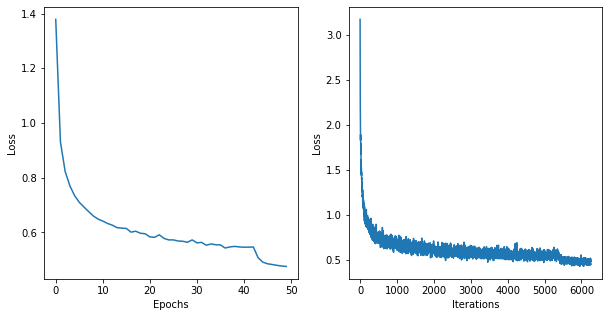

In [640]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(epoch_losses)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")

ax2.plot(iteration_losses)
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Loss")

plt.show()

## 7. Make predictions

In [641]:
def decode_predictions(text_batch_logits):

    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [idx2char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

In [642]:
results_train = pd.DataFrame(columns=['actual', 'prediction'])
train_loader = DataLoader(trainset, batch_size=16, num_workers=0, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(train_loader, leave=True):
        text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_train = pd.concat([results_train, df])
results_train = results_train.reset_index(drop=True)

  0%|          | 0/499 [00:00<?, ?it/s]

In [643]:
results_test = pd.DataFrame(columns=['actual', 'prediction'])
test_loader = DataLoader(testset, batch_size=16, num_workers=0, shuffle=False)
with torch.no_grad():
    for image_batch, text_batch in tqdm(test_loader, leave=True):
        text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
        text_batch_pred = decode_predictions(text_batch_logits.cpu())
        #print(text_batch, text_batch_pred)
        df = pd.DataFrame(columns=['actual', 'prediction'])
        df['actual'] = text_batch
        df['prediction'] = text_batch_pred
        results_test = pd.concat([results_test, df])
results_test = results_test.reset_index(drop=True)

  0%|          | 0/167 [00:00<?, ?it/s]

In [644]:
print(results_train.shape)
results_train.head()

(7983, 2)


,actual,prediction
0,526896.0,52668996.0
1,108588.0,108858-8.0
2,431846.0,43118446.0
3,886897.0,8-868897.0
4,2079.0,20007799.0


In [645]:
print(results_test.shape)
results_test.head()

(2661, 2)


,actual,prediction
0,28950.0,28899500.0
1,1011120.0,101-1120.0
2,31244.0,312244-4.0
3,1064401.0,10644401.0
4,nan,nnaann----


In [646]:
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [647]:
results_train['prediction_corrected'] = results_train['prediction'].apply(correct_prediction)
results_train.head()

,actual,prediction,prediction_corrected
0,526896.0,52668996.0,526896.0
1,108588.0,108858-8.0,108588.0
2,431846.0,43118446.0,431846.0
3,886897.0,8-868897.0,886897.0
4,2079.0,20007799.0,2079.0


In [648]:
results_test['prediction_corrected'] = results_test['prediction'].apply(correct_prediction)
results_test.head()

,actual,prediction,prediction_corrected
0,28950.0,28899500.0,28950.0
1,1011120.0,101-1120.0,101120.0
2,31244.0,312244-4.0,31244.0
3,1064401.0,10644401.0,106401.0
4,nan,nnaann----,nan


## 8. Evaluate the model

In [649]:
mistakes_df = results_test[results_test['actual'] != results_test['prediction_corrected']]
mistakes_df

,actual,prediction,prediction_corrected
1,1011120.0,101-1120.0,101120.0
3,1064401.0,10644401.0,106401.0
6,1082007.0,10820007.0,108207.0
13,1135765.0,1-135665.0,113565.0
21,81811.0,81188111.0,8181.0
...,...,...,...
2608,499159.0,49-99559.0,49959.0
2616,1229210.0,12-22210.0,12210.0
2623,117105.0,1-111005.0,1105.0
2631,113990.0,1-139990.0,11390.0


In [650]:
print(mistakes_df['prediction_corrected'].str.len().value_counts())

7    116
8     63
6     53
5     22
4      4
Name: prediction_corrected, dtype: int64


In [651]:
mask = mistakes_df['prediction_corrected'].str.len() >= 0
mistakes_df[mask]

,actual,prediction,prediction_corrected
1,1011120.0,101-1120.0,101120.0
3,1064401.0,10644401.0,106401.0
6,1082007.0,10820007.0,108207.0
13,1135765.0,1-135665.0,113565.0
21,81811.0,81188111.0,8181.0
...,...,...,...
2608,499159.0,49-99559.0,49959.0
2616,1229210.0,12-22210.0,12210.0
2623,117105.0,1-111005.0,1105.0
2631,113990.0,1-139990.0,11390.0


In [652]:
# mistake_image_fp = os.path.join(data_path, mistakes_df[mask]['actual'].values[0] + ".png")
# print(mistake_image_fp)
# mistake_image = Image.open(mistake_image_fp)
# plt.imshow(mistake_image)
# plt.show()

In [653]:
train_accuracy = accuracy_score(results_train['actual'], results_train['prediction_corrected'])
print(train_accuracy)
test_accuracy = accuracy_score(results_test['actual'], results_test['prediction_corrected'])
print(test_accuracy)

0.9351121132406364
0.90304396843292


In [654]:
torch.save(crnn, "crnn.pt")